In [1]:
!wget https://nuws.co/datahack-dataset
!tar xvf datahack-dataset

--2021-10-09 00:21:55--  https://nuws.co/datahack-dataset
Resolving nuws.co (nuws.co)... 52.72.49.79
Connecting to nuws.co (nuws.co)|52.72.49.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://numadic-datatrax.s3.ap-south-1.amazonaws.com/numadic-customer-transaction-prediction.tar.xz [following]
--2021-10-09 00:21:56--  https://numadic-datatrax.s3.ap-south-1.amazonaws.com/numadic-customer-transaction-prediction.tar.xz
Resolving numadic-datatrax.s3.ap-south-1.amazonaws.com (numadic-datatrax.s3.ap-south-1.amazonaws.com)... 52.219.64.115
Connecting to numadic-datatrax.s3.ap-south-1.amazonaws.com (numadic-datatrax.s3.ap-south-1.amazonaws.com)|52.219.64.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 224010468 (214M) [application/x-www-form-urlencoded]
Saving to: ‘datahack-dataset’

datahack-dataset    100%[===================>] 213.63M  22.7MB/s    in 11s     

2021-10-09 00:22:07 (20.0 MB/s) - ‘datahack-datas

## Importing libaries


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from torchsummary import summary
from tqdm import tqdm
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## Data Exploration



In [4]:
dir = "/content/numadic-customer-transaction-prediction"
train_df = pd.read_csv(dir+"/train.csv")
test_df = pd.read_csv(dir+"/test.csv")
train_df.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,7.567236,0.394340,-3.245596,14.023978,8.530232,7.537606,14.573126,9.333264,-5.696731,15.244013,12.438567,13.290894,17.257883,4.305430,3.019540,10.584400,13.667496,-4.055133,-1.137908,5.532980,5.053874,-7.687740,10.393046,-0.512886,14.774147,11.434250,3.842499,2.187230,5.868899,10.642131,...,24.259300,5.633293,5.362896,11.002170,-2.871906,19.315753,2.963335,-4.151155,4.937124,5.636008,-0.004962,-0.831777,19.817094,-0.677967,20.210677,11.640613,-2.799585,11.882933,-1.014064,2.591444,-2.741666,10.085518,0.719109,8.769088,12.756676,-3.983261,8.970274,-10.335043,15.377174,0.746072,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,1.235070,5.500793,5.970253,0.190059,4.639536,2.247908,0.411711,2.557421,6.712612,7.851370,7.996694,5.876254,8.196564,2.847958,0.526893,3.777245,0.285535,5.922210,1.523714,0.783367,2.615942,7.965198,2.159891,2.587830,4.322325,0.541614,5.179559,3.119978,2.249730,4.278903,...,10.880263,0.217938,1.419612,5.262056,5.457784,5.024182,0.369684,7.798020,3.105986,0.369437,4.424621,5.378008,8.674171,5.966674,7.136427,2.892167,7.513939,2.628895,8.579810,2.798956,5.261243,1.371862,8.963434,4.474924,9.318280,4.725167,3.189759,11.574708,3.944604,0.976348,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,3.970500,-20.731300,-26.095000,13.434600,-6.011100,1.013300,13.076900,0.635100,-33.380200,-10.664200,-12.402500,-5.432200,-10.089000,-5.322500,1.209800,-0.678400,12.720000,-24.243100,-6.166800,2.089600,-4.787200,-34.798400,2.140600,-8.986100,1.508500,9.816900,-16.513600,-8.095100,-1.183400,-6.337100,...,-7.452200,4.852600,0.623100,-6.531700,-19.997700,3.816700,1.851200,-35.969500,-5.250200,4.258800,-14.506000,-22.479300,-11.453300,-22.748700,-2.995300,3.241500,-29.116500,4.952100,-29.273400,-7.856100,-22.037400,5.416500,-26.001100,-4.808200,-18.489700,-22.583300,-3.022300,-47.753600,4.412300,-2.554300,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.26

### Cleaning dataset
1) Getting rid of Missing values (if any)

2) Deleting Duplicates (if any)

In [5]:
# Missing Values
train_df.dropna(inplace=True)

# Duplicates
train_df.drop_duplicates(inplace=True)

### Checking class distribution

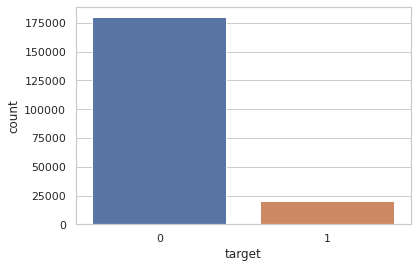

In [6]:
distri = train_df['target'].value_counts().to_frame()
distri.rename(columns={"target":"count"}, inplace=True)
distri["target"] = distri.index
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="target", y="count", data=distri)

We see a huge imbalance in the training data



## Data Preprocessing

### Fixing the Imbalance issue

Using oversampling to tackle this issue



In [7]:
sampler = SMOTE()
data_x, data_y = sampler.fit_resample(train_df.drop(["target", "ID_code"], axis=1), train_df["target"])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [8]:
count = np.bincount(data_y)
count

array([179902, 179902])

this fixes the issue of the imbalance by creating equal datapoints of each class

### Normalizing Data

In [9]:
norm = MinMaxScaler()
norm.fit(data_x)
data_x = norm.transform(data_x)

### Data Splitting

In [10]:
train_x, val_x, train_y, val_y = train_test_split(data_x, data_y, test_size=0.2, random_state=42)

### Creating DataLoaders

In [11]:
batch_size = 128

train_x = torch.Tensor(train_x)
train_y = torch.Tensor(train_y)
val_x = torch.Tensor(val_x)
val_y = torch.Tensor(val_y)

train_set = TensorDataset(train_x, train_y)
val_set = TensorDataset(val_x, val_y)

trainloader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
valloader = DataLoader(val_set, shuffle=True, batch_size=batch_size)

## Model Generation

In [12]:
Model = nn.Sequential(nn.Linear(200, 800),
                      nn.ReLU(inplace=True),
                      nn.Linear(800, 1200),
                      nn.ReLU(inplace=True),
                      nn.Linear(1200, 900),
                      nn.ReLU(inplace=True),
                      nn.Linear(900, 400),
                      nn.ReLU(inplace=True),
                      nn.Linear(400, 100),
                      nn.ReLU(inplace=True),
                      nn.Linear(100, 1),
                      nn.Sigmoid()
                     )
Model.to(device=DEVICE)
summary(Model, (1, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 800]         160,800
              ReLU-2               [-1, 1, 800]               0
            Linear-3              [-1, 1, 1200]         961,200
              ReLU-4              [-1, 1, 1200]               0
            Linear-5               [-1, 1, 900]       1,080,900
              ReLU-6               [-1, 1, 900]               0
            Linear-7               [-1, 1, 400]         360,400
              ReLU-8               [-1, 1, 400]               0
            Linear-9               [-1, 1, 100]          40,100
             ReLU-10               [-1, 1, 100]               0
           Linear-11                 [-1, 1, 1]             101
          Sigmoid-12                 [-1, 1, 1]               0
Total params: 2,603,501
Trainable params: 2,603,501
Non-trainable params: 0
---------------------------

### Creating HyperParameters

In [13]:
LEARNING_RATE = 0.0001
EPOCHS = 5
LOSS_FUNCTION = nn.BCELoss()
OPTIMIZER = optim.Adam(Model.parameters(), lr=LEARNING_RATE)

### Training the model

In [14]:
Model.train()

for epoch in range(EPOCHS):
  loop = tqdm(trainloader)
  acc = 0
  avg_loss = 0

  for batch_idx, (inp, targets) in enumerate(loop):
    OPTIMIZER.zero_grad()

    inp = inp.to(device=DEVICE)
    targets = targets.to(device=DEVICE)

    outputs = Model(inp)
    outputs = outputs.reshape_as(targets)

    loss = LOSS_FUNCTION(outputs, targets)
    loss.backward()
    OPTIMIZER.step()

    outputs = torch.round(outputs)

    acc += torch.mean((outputs == targets).type(torch.FloatTensor)).item()
    avg_loss += loss.item()

    loop.set_postfix(batch_no=batch_idx+1, loss=avg_loss/(batch_idx+1), accuracy=acc*100/(batch_idx+1))



100%|██████████| 2249/2249 [00:26<00:00, 85.62it/s, accuracy=89.8, batch_no=2249, loss=0.242]


### Checking model accuracy on Val set

In [15]:
Model.eval()
with torch.no_grad():
  loop = tqdm(trainloader)
  acc = 0
  avg_loss = 0
  
  for batch_idx, (inp, targets) in enumerate(loop):
    inp = inp.to(device=DEVICE)
    targets = targets.to(device=DEVICE)

    outputs = Model(inp)
    
    outputs = outputs.reshape_as(targets)
    outputs = torch.round(outputs)

    acc += torch.mean((outputs == targets).type(torch.FloatTensor)).item()
    avg_loss += loss.item()

    loop.set_postfix(batch_no=batch_idx+1, loss=avg_loss/(batch_idx+1), accuracy=acc*100/(batch_idx+1))

100%|██████████| 2249/2249 [00:15<00:00, 148.60it/s, accuracy=90.7, batch_no=2249, loss=0.28]


## Generating outputs for the Test csv
No data cleaning will be performed on this data as every datapoint needs to be mapped

The only Preprocessing step that will be followed is that of the Normalization

In [56]:
test_data = norm.transform(test_df.drop(["ID_code"], axis=1))
test_data = torch.Tensor(test_data)
no_labels = torch.zeros(test_data.shape[0])
testset = TensorDataset(test_data, no_labels)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

preds = []

Model.eval()
with torch.no_grad():
  for inp, lab in testloader:
    inp = inp.to(device=DEVICE)
    outputs = Model(inp)

    outputs = outputs.reshape_as(lab)
    outputs = torch.round(outputs)

    for out in outputs:
      preds.append(out.item())

test_df["target"] = preds
test_df.head(20)

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,target
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,-2.0248,-4.3554,13.9696,0.3458,7.5408,14.5001,7.7028,-19.0919,15.5806,16.1763,3.7088,18.8064,1.5899,3.0654,6.4509,14.1192,-9.4902,-2.1917,5.7107,3.7864,-1.7981,9.2645,2.0657,12.7753,11.3334,8.1462,-0.0610,3.5331,9.7804,...,5.4113,3.8302,5.7380,-8.6105,22.9530,2.5531,-0.2836,4.3416,5.1855,4.2603,1.6779,29.0849,8.4685,18.1317,12.2818,-0.6912,10.2226,-5.5579,2.2926,-4.5358,10.3903,-15.4937,3.9697,31.3521,-1.1651,9.2874,-23.5705,13.2643,1.6591,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197,0.0
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,-1.3809,-0.3310,14.1129,2.5667,5.4988,14.1853,7.0196,4.6564,29.1609,0.0910,12.1469,3.1389,5.2578,2.4228,16.2064,13.5023,-5.2341,-3.6648,5.7080,2.9965,-10.4720,11.4938,-0.9660,15.3445,10.6361,0.8966,6.7428,2.3421,12.8678,...,5.6723,3.6873,13.0429,-10.6572,15.5134,3.2185,9.0535,7.0535,5.3924,-0.7720,-8.1783,29.9227,-5.6274,10.5018,9.6083,-0.4935,8.1696,-4.3605,5.2110,0.4087,12.0030,-10.3812,5.8496,25.1958,-8.8468,11.8263,-8.7112,15.9072,0.9812,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760,0.0
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,8.3442,-4.7057,-3.0422,13.6751,3.8183,10.8535,14.2126,9.8837,2.6541,21.2181,20.8163,12.4666,12.3696,4.7473,2.7936,5.2189,13.5670,-15.4246,-0.1655,7.2633,3.4310,-9.1508,9.7320,3.1062,22.3076,11.9593,9.9255,4.0702,4.9934,8.0667,...,5.5228,3.3159,4.3324,-0.5382,13.3009,3.1243,-4.1731,1.2330,6.1513,-0.0391,1.4950,16.8874,-2.9787,27.4035,15.8819,-10.9660,15.6415,-9.4056,4.4611,-3.0835,8.5549,-2.8517,13.4770,24.4721,-3.4824,4.9178,-2.0720,11.5390,1.1821,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794,0.0
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,7.4578,0.0095,-5.0659,14.0526,13.5010,8.7660,14.7352,10.0383,-15.3508,2.1273,21.4797,14.5372,12.5527,2.9707,4.2398,13.7796,14.1408,1.0061,-1.3479,5.2570,6.5911,6.2161,9.5540,2.3628,10.2124,10.8047,-2.5588,6.0720,3.2613,16.5632,...,5.3882,3.6775,7.4753,-11.0780,24.8712,2.6415,2.2673,7.2788,5.6406,7.2048,3.4504,2.4130,11.1674,14.5499,10.6151,-5.7922,13.9407,7.1078,1.1019,9.4590,9.8243,5.9917,5.1634,8.1154,3.6638,3.3102,-19.7819,13.4499,1.3104,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108,0.0
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,7.1437,5.1025,-3.2827,14.1013,8.9672,4.7276,14.5811,11.8615,3.1480,18.0126,13.8006,1.6026,16.3059,6.7954,3.6015,13.6569,13.8807,8.6228,-2.2654,5.2255,7.0165,-15.6961,10.6239,-4.7674,17.5447,11.8668,3.0154,4.2546,6.7601,5.9613,...,5.6688,6.1159,13.2433,-11.9785,26.2040,3.2348,-5.5775,5.7036,6.1717,-1.6039,-2.4866,17.2728,2.3640,14.0037,12.9165,-12.0311,10.1161,-8.7562,6.0889,-1.3620,10.3559,-7.4915,9.4588,3.9829,5.8580,8.3635,-24.8254,11.4928,1.6321,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846,0.0
5,test_5,5.9862,-2.2913,8.6058,7.0685,14.2465,-8.6761,4.2467,14.7632,1.8790,7.2842,-4.9194,-9.1869,14.0581,11.4403,4.2950,13.8808,10.9588,-7.0124,15.1829,18.2710,9.7086,22.9103,6.5080,2.3607,1.7899,13.9555,-7.2154,-2.4084,5.1616,6.9291,0.1141,9.7667,1.2339,17.7117,12.3433,-0.1787,-1.2858,5.5220,13.0498,...,5.6731,5.2368,5.2973,-13.2809,26.6861,3.0711,-5.8410,3.2268,5.

### Saving the CSV

In [57]:
submission_df = test_df[["ID_code","target"]]
submission_df.to_csv("/content/submission.csv")